# BDA project "Pump It Up"

- Анастасия Барковая
- Варвара Михайлова
- Анна Снигирева

# 1. Проблема

В соответствии с [water.org ](https://water.org ), 4 миллиона человек в Танзании не имеют доступа к улучшенному источнику безопасной воды.

Люди, живущие в таких условиях, тратят значительное количество времени на поездки на большие расстояния, чтобы набрать воды в пунктах сбора воды.

Точное предсказание того, функционируют насосы или нет, действительно важно, поскольку люди подвергаются риску ухудшения здоровья или даже смерти от обезвоживания.

![image.png](attachments/image.png)

Используя данные Taarifa и Министерства водного хозяйства Танзании, мы должны понимать, какие насосы исправны, какие нуждаются в некотором ремонте, а какие вообще не работают. Прогноз будет основан на ряде переменных, касающихся того, какой тип насоса работает, когда он был установлен и как им управляют. Четкое понимание того, какие пункты водоснабжения выйдут из строя, может улучшить операции по техническому обслуживанию и обеспечить доступность чистой питьевой воды для населения по всей Танзании.

[Ссылка на конкурс](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table )

# 2. Подгрузка датасета

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
try:
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
except:
    !pip install cartopy
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs

In [46]:
X = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", index_col=0)
y = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", index_col=0)
assert (X.index == y.index).all()

In [47]:
pd.options.display.max_columns = 41
y.head(5)

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


Посмотрим, сколько всего количественных и категориальных признаков

In [48]:
cat_features = 0
numeric_features = 0
for column, tp in X.dtypes.items():
    if str(tp) == 'object':
        cat_features += 1
    else:
        numeric_features += 1
print(f'There are {cat_features} categorial features and {numeric_features} numeric features.')

There are 30 categorial features and 9 numeric features.


Посмотрим, сколько N/A признаков

In [49]:
y.isna().sum()

status_group    0
dtype: int64

In [50]:
categorial_nan_count = X.select_dtypes(include=['object']).isna().sum()
numeric_nan_count = X.select_dtypes(exclude=['object']).isna().sum()
print(f'NaN in Categorial:\n{(categorial_nan_count != 0).sum()}')
print(f'NaN in Numerics:\n{(numeric_nan_count != 0).sum()}')


NaN in Categorial:
7
NaN in Numerics:
0


Как видим, NaN встречается только в категориальных признаках, поэтому заменим строкой "None"

In [51]:
X.fillna(value="None", inplace=True)

Составим общую таблицу, соединив X и y

In [52]:
df = pd.merge(X, y, on='id', how='inner')
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,None,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,None,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,None,None,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [53]:
df

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,None,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,None,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,None,None,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37057,0.0,2011-04-11,None,0,None,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,None,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional


# 3. Исследование датасета

### Посмотрим, какое распределение насосов каждого типа по глубине

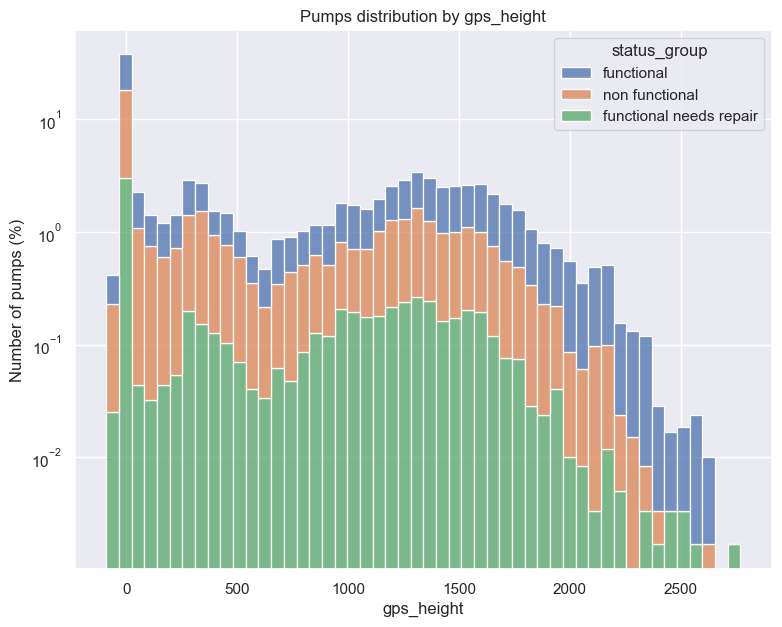

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.histplot(data=df, x="gps_height", hue="status_group", stat='percent', bins=50, multiple="stack");
plt.yscale('log')
plt.ylabel('Number of pumps (%)');
plt.title('Pumps distribution by gps_height');
plt.show()

### Посмотрим расположение точек на карте

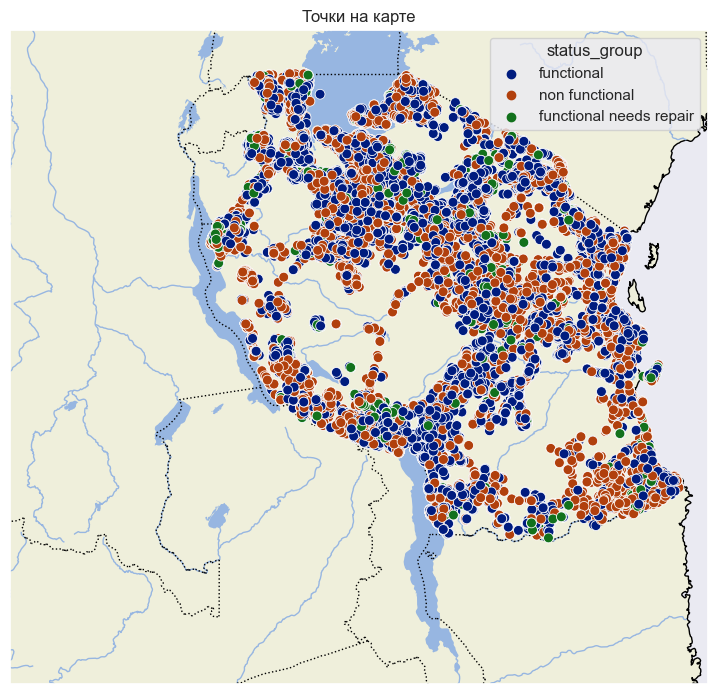

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 9))
min_lon = 25  # Минимальная долгота
max_lon = 41  # Максимальная долгота
min_lat = -15  # Минимальная широта
max_lat = 0   # Максимальная широта
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

sns.scatterplot(data = df, x = "longitude", y = "latitude", hue='status_group', marker='o',
                s=50, transform=ccrs.PlateCarree(), zorder=3, palette = "dark")
ax.set_title('Точки на карте')

plt.show()

### Рассмотрим cуммарное количество воды по географическим локациям:

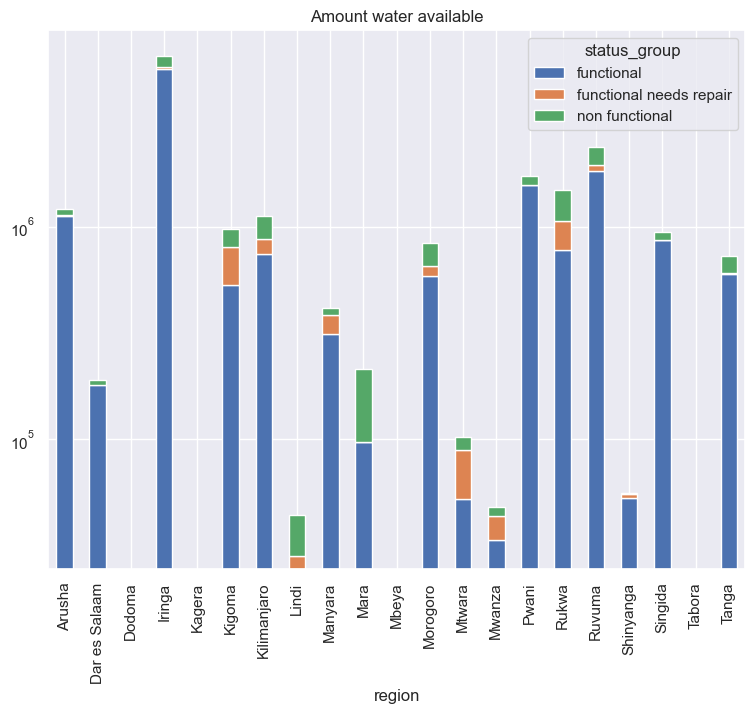

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))


_data = df.groupby(["region", "status_group"])['amount_tsh'].sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
#plt.ylabel('Number of pumps (%)');
plt.title('Amount water available');
plt.show()

### Видно, что от местности к местности, значения меняются. Поэтому рассмотрим количество воды в насосах на душу населения рядом с насосом в зависимости от региона

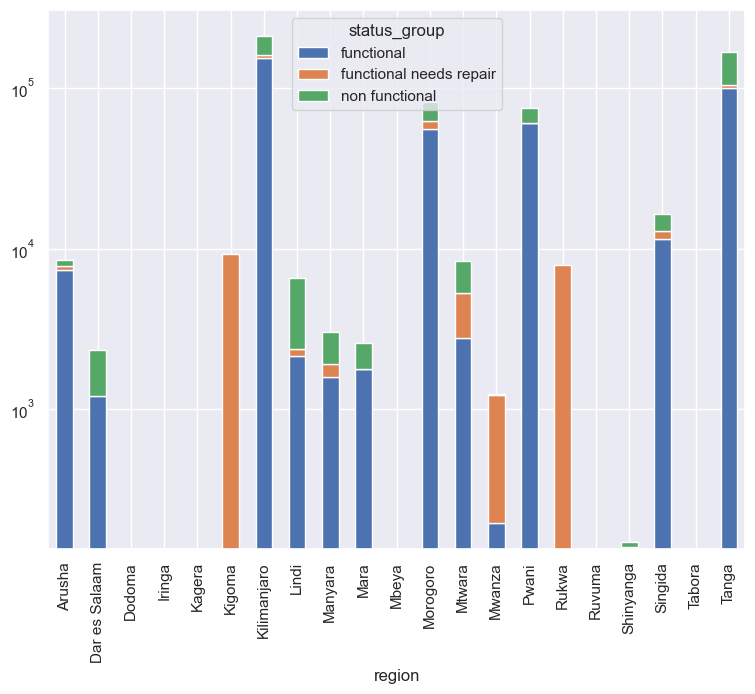

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

df['amount_per_one'] = df['amount_tsh']/df['population']
_data = df.groupby(["region", "status_group"])
_data = _data.amount_per_one.sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
plt.show()

### Посмотрим на основные источники водоснабжения

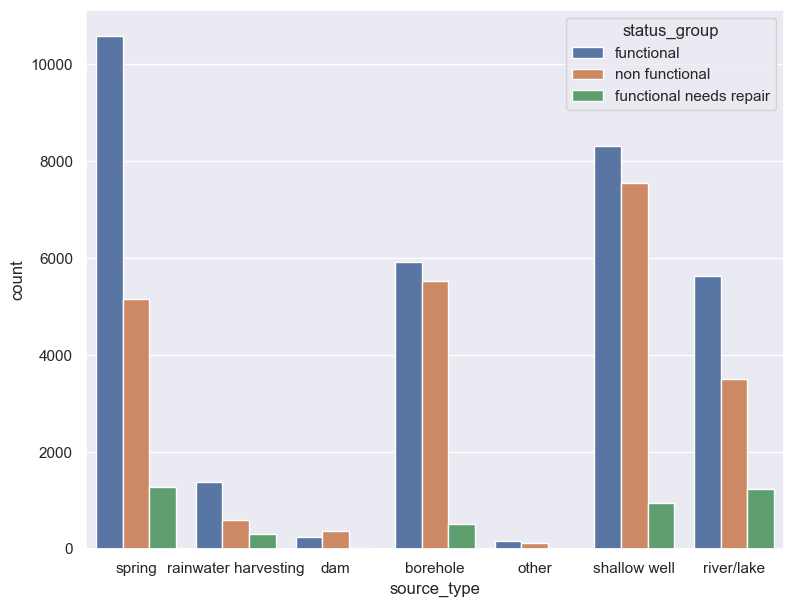

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.countplot(data = df, x = 'source_type', hue = 'status_group')
plt.show()

Самыми популярными являются родник и неглубокий колодец. Для родников преобладают функционирующие насосы, в то время как для колодцев число функционирующих и нефункционирующих примерно одинаково.

### Определим зависимость функционирования насоса от платежа за воду

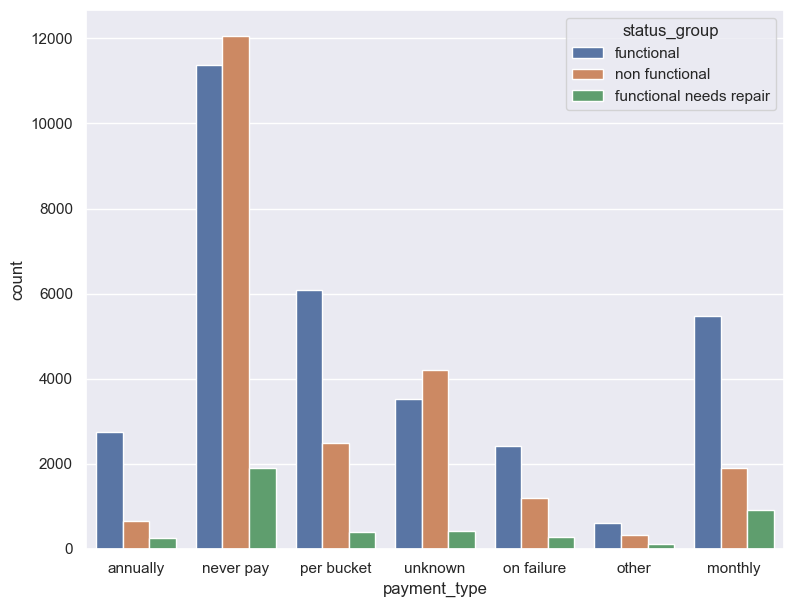

In [16]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.countplot(data = df, x = 'payment_type', hue = 'status_group')
plt.show()

Из графика видно, если оплачивать воду, то часть средств будут уходить на обслуживание точки, и, следовательно, вероятность функционирования точки будет выше.

### Посмотрим распредление качества воды исходя из доступного количества воды

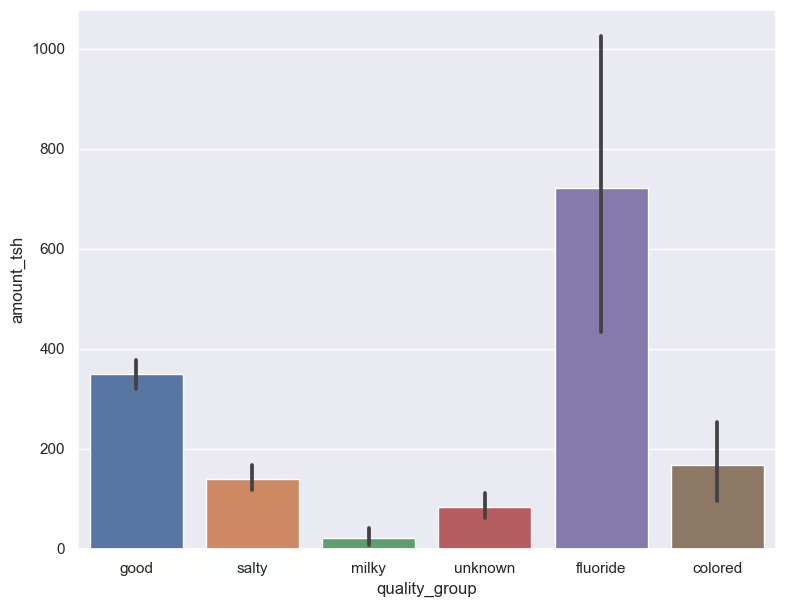

In [17]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=df, x='quality_group', y='amount_tsh')
plt.show()

Можно видеть, что больше всего доступной воды относится к фторсодержащей и хорошей по качеству. Это говорит о том, что большинство воды, которую можно добыть в этих точках, можно использовать как питьевую.

### Рассмотрим распределение функциональных и нефункциональных колодцев среди всего населения Танзании

In [18]:
functional = []
non_functional = []
so_so = []
for i,r in df.iterrows():
    if r['status_group'] == 'functional':
        functional.append(r['population'])
    elif r['status_group'] == 'functional needs repair':
        so_so.append(r['population'])
    else:
        non_functional.append(r['population'])

In [19]:
funct = sum(functional)
nfunct = sum(non_functional)
so = sum(so_so)

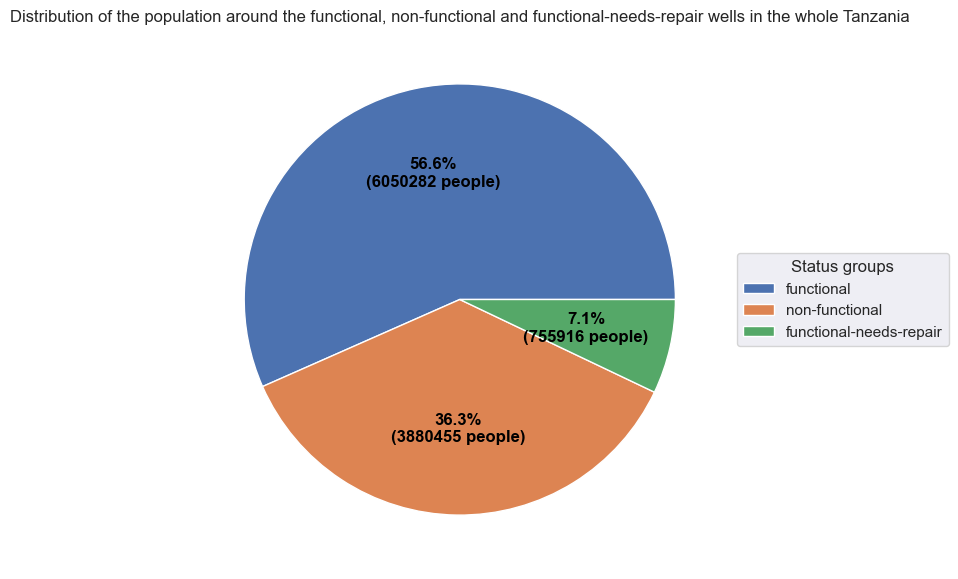

In [20]:
fig, ax = plt.subplots(figsize=(9, 7), subplot_kw=dict(aspect="equal"))

distribution = ["6050282 functional",
              "3880455 non-functional",
               "755916 functional-needs-repair"]

data = [float(x.split( )[0]) for x in distribution]
wells = [x.split( )[-1] for x in distribution]

def func(pct,allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} people)"

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"))

ax.legend(wedges, wells,
          title="Status groups",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Distribution of the population around the functional, non-functional and functional-needs-repair wells in the whole Tanzania")

plt.show()

Из представленной круговой диаграммы видно, что почти половина населения Танзании не имеет доступа к полноценно функционирующим колодцам.

### График, отражающий зависимость колодцев с хорошей водой от общего количества функционирующих колодцев, а также от года постройки колодца

In [60]:
years = []
for i,r in df.iterrows():
    years.append(r.construction_year)
years = np.array(years)
years = np.unique(years)
years = np.delete(years,0)

In [22]:
res1 = []
for i in years:
    mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.quality_group == 'good')
    res1.append(len(df[mask]))

In [23]:
res2 = []
for i in years:
    mask = (df.construction_year == i) & (df.status_group == 'functional')
    res2.append(len(df[mask]))

In [24]:
tdf = pd.DataFrame()
tdf['years'] = years
tdf['good_water_wells'] = res1
tdf['functional_wells'] = res2

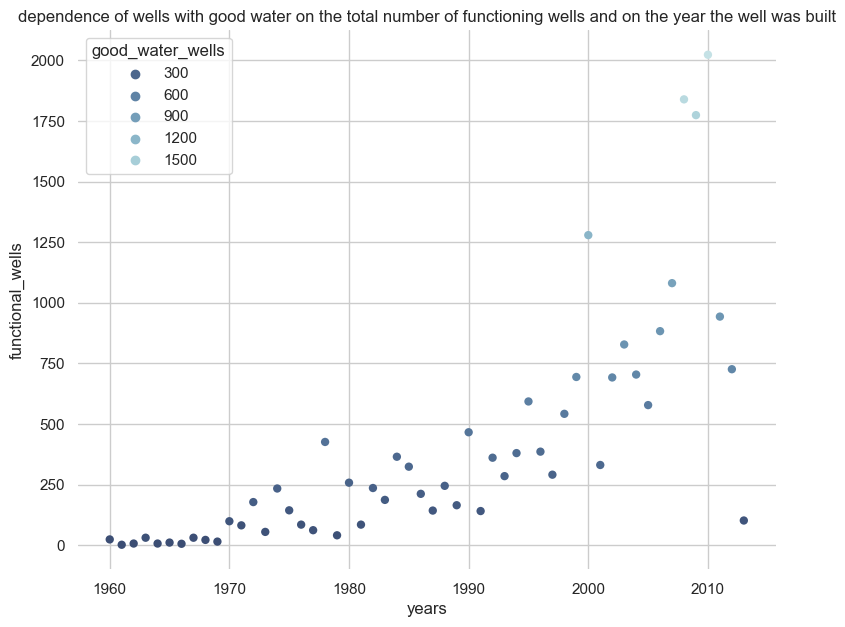

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(9, 7))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="years", y="functional_wells",
                hue="good_water_wells",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=tdf, ax=ax)
plt.title('dependence of wells with good water on the total number of functioning wells and on the year the well was built')
plt.show()

Из графика видно, что с течением времени количество функционирующих колодцев с хорошей водой увеличивалось.

### Рассмотрим распределние добычи воды на декаду

In [26]:
a = ['gravity','handpump','motorpump','rope pump','submersible','wind-powered']
res_0 = []
res_1 = []
res_2 = []
res_3 = []
res_4 = []
res_5 = []
res = [res_0,res_1,res_2,res_3,res_4,res_5]
for i in years:
    for j in a:
        mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.extraction_type_class == f'{j}')
        ind = a.index(j)
        res[ind].append(len(df[mask]))

In [27]:
tdf3 = pd.DataFrame()
tdf3['years'] = years
tdf3['gravity'] = res_0
tdf3['handpump'] = res_1
tdf3['motorpump'] = res_2
tdf3['rope_pump'] = res_3
tdf3['submersible'] = res_4
tdf3['wind_powered'] =res_5

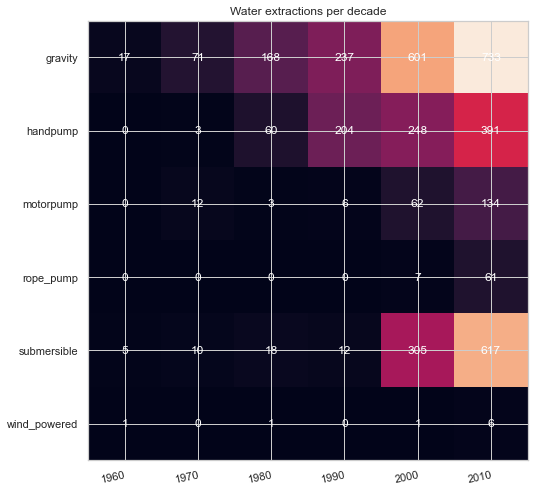

In [190]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


extraction_types = ["gravity", "handpump", "motorpump", "rope_pump",
              "submersible", "wind_powered"]
year = []
indexies = []
for i in years:
    if str(i)[-1] == '0':
        year.append(i)
        indexies.append(list(years).index(i))

harvest = np.array([[res_0[i] for i in indexies],
                    [res_1[i] for i in indexies],
                    [res_2[i] for i in indexies],
                    [res_3[i] for i in indexies],
                    [res_4[i] for i in indexies],
                    [res_5[i] for i in indexies]])


fig, ax = plt.subplots(figsize=(9, 7))

im = ax.imshow(harvest)

ax.set_xticks(np.arange(len(year)), labels=year)
ax.set_yticks(np.arange(len(extraction_types)), labels=extraction_types)

plt.setp(ax.get_xticklabels(), rotation=12, ha="right",
         rotation_mode="anchor")


for i in range(len(extraction_types)):
    for j in range(len(year)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Water extractions per decade")
fig.tight_layout()
plt.show()

In [75]:
rows = df.shape[0]

In [76]:
rows

59400

In [40]:
mask = (df.status_group == 'functional') & (df.payment_type == 'monthly')
n1 = df[mask].shape[0]
n1

5482

In [41]:
mask = (df.status_group == 'non functional') & (df.payment_type == 'monthly')
n2 = df[mask].shape[0]
n2

1891

### Сформулируем нулевую гипотезу:

H0: mu1 = mu2, количество воды, доступное в точках, в период с 1960 по 1985 г равно количеству воды, доступному в точках, в период с 1985 по 2010 г.

### Сформулируем альтернативную гипотезу:

H1: mu1 != mu2, количество воды, доступное в точках, в период с 1960 по 1985 г не равно количеству воды, доступному в точках, в период с 1985 по 2010 г.

Выберем уровень значимости = 0.05

### Расчитаем значение статистики:

In [ ]:
sd1 = np.std(sample_1)
sd2 = np.std(sample_2)
z1 = np.mean(sample_1) - np.mean(sample_2)
z2 = np.sqrt(sd1**2/len(sample_1) + sd2**2/len(sample_2))

In [120]:
df_0 = df.loc[df['construction_year'] > 0]

In [121]:
df_1 = df_0.loc[df_0['construction_year'] < 1986]

In [122]:
df_2 = df_0.loc[df_0['construction_year'] > 1985]

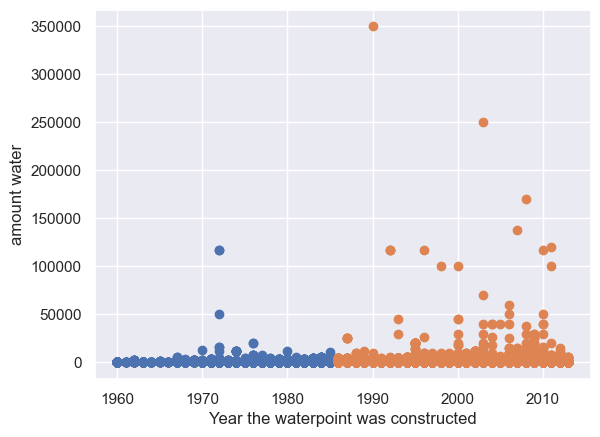

In [124]:
plt.scatter(x = 'construction_year', y = 'amount_tsh', data=df_1)
plt.ylabel('amount water')
plt.xlabel('Year the waterpoint was constructed')
plt.scatter(x = 'construction_year', y = 'amount_tsh', data=df_2)
plt.show()

In [125]:
sample_1 = df_1['amount_tsh'].to_numpy()
sample_2 = df_2['amount_tsh'].to_numpy()

In [128]:
sd1 = np.std(sample_1)
sd2 = np.std(sample_2)
t1 = np.mean(sample_1) - np.mean(sample_2)
t2 = np.sqrt(sd1**2/len(sample_1) + sd2**2/len(sample_2))
statistic = t1/t2

In [129]:
statistic

-6.951216714531085

In [131]:
import scipy.stats as stats

In [132]:
pval = 2 * (1 - stats.t.cdf(np.abs(statistic), df = len(sample_1) + len(sample_2) - 2))

In [133]:
pval

3.678835014397919e-12

In [134]:
pval< 0.05

True

### Вывод

Значение pval оказалось гораздо меньше выбранного нами уровня значимости, следовательно, нулевая гипотеза неверна и нужно ее отвергнуть.

это может говорить о том, что строительство колодцев с течением времени происходило неравномерно и с каждым годом улучшалось.